In [1]:
from Scripts.ProcessingEmbeddings import *
from Scripts.HardDebias import *
from Scripts.utils import *

In [2]:
import codecs
import json
import numpy as np
import sklearn

In [3]:
glove=Embeddings('Data/glove-wiki-gigaword-300.txt', gensim=False)

Loading Data/glove-wiki-gigaword-300.txt embeddings
vectors shape: (400000, 300), word2idx length: 400000, vocab length: 400000


In [4]:
vectors=glove.vectors
word2idx=glove.word2idx
vocab=glove.words
dict_vectors = glove.get_word_vector_dict()


In [5]:
np.isnan(vectors).any()

False

In [6]:
# Getting a limited vocabulary to debias the embeddings.
vocab_cleaned, vectors_cleaned, word2idx_cleaned, dict_vec_cleaned = glove.limit_vocab(vectors, word2idx, vocab)

100%|██████████| 400000/400000 [00:00<00:00, 627710.58it/s]


Size of limited vocabulary: 327185


## Hard-Debias Algorithm

#### Preliminaries

In [7]:
#Gender specific vocabulary:
gender_specific=[]
female_vocab=[]
male_vocab=[]
with open('./Data/male_word_file.txt') as f:
    male_vocab = [line.strip() for line in f]

with open('./Data/female_word_file.txt') as f:
    for l in f:
        female_vocab.append(l.strip())

gender_specific=female_vocab+female_vocab

with codecs.open('./Data/gender_specific_full.json') as f:
    gender_specific.extend(json.load(f))

In [8]:
#Getting the definitional sets to calculate afterwards the gender direction. The first 10 gender sets were proposed by Bolukbasi et al. (2016)
#Definitional sets for race where proposed by Manzini et al. in Multiclass debiasing of embeddings: https://github.com/TManzini/DebiasMulticlassWordEmbedding/blob/master/Debiasing/data/vocab/race_attributes_optm.json

def_sets = {
    "gender": [
        ['she', 'he'], ['herself', 'himself'], [
            'her', 'his'], ['daughter', 'son'], ['girl', 'boy'],
        ['mother', 'father'], ['woman', 'man'], ['mary', 'john'], ['gal', 'guy'], ['female', 'male'], ['aunt', 'uncle']],

    "race": [
        ["black", "caucasian", "asian", "hispanic"],
      		["african", "caucasian", "asian", "hispanic"],
      		["black", "white", "asian", "latino"],
      		["africa", "europe", "asia", "mexico"],
      		["africa", "america", "china", "latin-america"],
    ]
}

#Equalizing pairs for gender debiasing were first published by Bolukbasi et al. in https://github.com/tolga-b/debiaswe/blob/master/data/equalize_pairs.json
# Equalizing sets for race where defined by Manzini as equal to the defining set (Manzini et al., 2019.p.3)
equalizing_lists = {
    "gender": [
        ["monastery", "convent"], ["spokesman", "spokeswoman"], [
            "Catholic_priest", "nun"], ["Dad", "Mom"], ["Men", "Women"],
        ["councilman", "councilwoman"], ["grandpa", "grandma"], [
            "grandsons", "granddaughters"], ["prostate_cancer", "ovarian_cancer"],
        ["testosterone", "estrogen"], ["uncle", "aunt"], [
            "wives", "husbands"], ["Father", "Mother"], ["Grandpa", "Grandma"],
        ["He", "She"], ["boy", "girl"], ["boys", "girls"], ["brother", "sister"], [
            "brothers", "sisters"], ["businessman", "businesswoman"],
        ["chairman", "chairwoman"], ["colt", "filly"], ["congressman",
                                                        "congresswoman"], ["dad", "mom"], ["dads", "moms"], ["dudes", "gals"],
        ["ex_girlfriend", "ex_boyfriend"], ["father", "mother"], [
            "fatherhood", "motherhood"], ["fathers", "mothers"], ["fella", "granny"],
        ["fraternity", "sorority"], ["gelding", "mare"], ["gentleman", "lady"], [
            "gentlemen", "ladies"], ["grandfather", "grandmother"],
        ["grandson", "granddaughter"], ["he", "she"], ["himself", "herself"], [
            "his", "her"], ["king", "queen"], ["kings", "queens"],
        ["male", "female"], ["males", "females"], ["man", "woman"], [
            "men", "women"], ["nephew", "niece"], ["prince", "princess"],
        ["schoolboy", "schoolgirl"], ["son", "daughter"], ["sons", "daughters"], ["twin_brother", "twin_sister"]]}

#Some of the words were taken from the analogies' templates from Cheng and Manzini.
#The list is not the same, however, because some of the words were not neutral, but carried some
#relation to the social categories.
neutral_words = ["manager", "executive", "doctor", "lawyer", "programmer",
                 "scientist", "soldier", "supervisor", "rancher", "janitor",
                 "firefighter", "officer", "secretary", "nurse", "clerk", "artist",
                 "homemaker", "dancer", "singer", "librarian", "maid", "hairdresser", "stylist",
                 "receptionist", "counselor", "leader", "farmer",
                 "engineer", "laborer", "teacher",
                 "slave", "musician", "runner", "criminal", "homeless",
                 "greedy", "cheap", "hairy", "liberal",
                 "judgemental", "conservative", "familial",
                 "violent", "terrorist", "dirty", "uneducated", "educated"]


#However, also the vocabulary without the gendered words from the list can be conceived as neutral, according to Bolukbasi et al.


In [9]:
#Lists of names for validation
#Adapted from Speer's tutorial on racism in sentiment analysis. http://blog.conceptnet.io/posts/2017/how-to-make-a-racist-ai-without-really-trying/
names_ethnicity = {
    # The first two lists are from the Caliskan et al. appendix describing the
    # Word Embedding Association Test.
    'White': [
        'Adam', 'Chip', 'Harry', 'Josh', 'Roger', 'Alan', 'Frank', 'Ian', 'Justin',
        'Ryan', 'Andrew', 'Fred', 'Jack', 'Matthew', 'Stephen', 'Brad', 'Greg', 'Jed',
        'Paul', 'Todd', 'Brandon', 'Hank', 'Jonathan', 'Peter', 'Wilbur', 'Amanda',
        'Courtney', 'Heather', 'Melanie', 'Sara', 'Amber', 'Crystal', 'Katie',
        'Meredith', 'Shannon', 'Betsy', 'Donna', 'Kristin', 'Nancy', 'Stephanie',
        'Bobbie-Sue', 'Ellen', 'Lauren', 'Peggy', 'Sue-Ellen', 'Colleen', 'Emily',
        'Megan', 'Rachel', 'Wendy'
    ],

    'Black': [
        'Alonzo', 'Jamel', 'Lerone', 'Percell', 'Theo', 'Alphonse', 'Jerome',
        'Leroy', 'Rasaan', 'Torrance', 'Darnell', 'Lamar', 'Lionel', 'Rashaun',
        'Tyree', 'Deion', 'Lamont', 'Malik', 'Terrence', 'Tyrone', 'Everol',
        'Lavon', 'Marcellus', 'Terryl', 'Wardell', 'Aiesha', 'Lashelle', 'Nichelle',
        'Shereen', 'Temeka', 'Ebony', 'Latisha', 'Shaniqua', 'Tameisha', 'Teretha',
        'Jasmine', 'Latonya', 'Shanise', 'Tanisha', 'Tia', 'Lakisha', 'Latoya',
        'Sharise', 'Tashika', 'Yolanda', 'Lashandra', 'Malika', 'Shavonn',
        'Tawanda', 'Yvette'
    ],

    # This list comes from statistics about common Hispanic-origin names in the US.
    'Hispanic': [
        'Juan', 'José', 'Miguel', 'Luís', 'Jorge', 'Santiago', 'Matías', 'Sebastián',
        'Mateo', 'Nicolás', 'Alejandro', 'Samuel', 'Diego', 'Daniel', 'Tomás',
        'Juana', 'Ana', 'Luisa', 'María', 'Elena', 'Sofía', 'Isabella', 'Valentina',
        'Camila', 'Valeria', 'Ximena', 'Luciana', 'Mariana', 'Victoria', 'Martina'
    ],


}
#Following Bolukbasi et al. Implementing notebook: https://github.com/tolga-b/debiaswe/blob/master/tutorial_example1.ipynb
names = ["Emily", "Aisha", "Anne", "Keisha", "Jill", "Tamika", "Allison", "Lakisha", "Laurie", "Tanisha", "Sarah",
         "Latoya", "Meredith", "Kenya", "Carrie", "Latonya", "Kristen", "Ebony", "Todd", "Rasheed", "Neil", "Tremayne",
         "Geoffrey", "Kareem", "Brett", "Darnell", "Brendan", "Tyrone", "Greg", "Hakim", "Matthew", "Jamal", "Jay",
         "Leroy", "Brad", "Jermaine"]
#names_group1 = [names[2 * i] for i in range(len(names) // 2)]
#names_group2 = [names[2 * i + 1] for i in range(len(names) // 2)]


In [10]:
euroam_names = ["Adam", "Alan", "Allison", "Amanda", "Amber", "Andrew", "Anne", "Betsy", "Bobbie-Sue", "Brad", "Brandon", "Brendan", "Brett", "Carrie", "Chip", "Colleen", "Courtney", "Crystal", "Donna", "Ellen", "Emily", "Frank", "Fred", "Geoffrey", "Greg", "Hank", "Harry", "Heather", "Ian", "Jack", "Jay",
                "Jed", "Jill", "Jonathan", "Josh", "Justin", "Katie", "Kristen", "Kristin", "Lauren", "Laurie", "Matthew", "Megan", "Melanie", "Meredith", "Nancy", "Neil", "Neil", "Paul", "Peggy", "Peter", "Rachel", "Roger", "Ryan", "Sara", "Sarah", "Shannon", "Stephanie", "Stephen", "Sue-Ellen", "Todd", "Wendy", "Wilbur"]

africanam_names = ["Aiesha", "Aisha", "Alonzo", "Alphonse", "Darnell", "Deion", "Ebony", "Everol", "Hakim", "Jamal", "Jamel", "Jasmine", "Jermaine", "Jerome", "Kareem", "Keisha", "Kenya", "Lakisha", "Lamar", "Lamont", "Lashandra", "Lashelle", "Latisha", "Latonya", "Latoya", "Lavon", "Lerone", "Leroy", "Lionel", "Malik", "Malika", "Marcellus", "Nichelle", "Percell", "Rasaan", "Rashaun", "Rasheed", "Shaniqua", "Shanise", "Sharise", "Shavonn", "Shereen", "Tameisha", "Tamika", "Tanisha",
                   "Tashika", "Tawanda", "Temeka", "Teretha", "Terrence", "Terryl", "Theo", "Tia", "Torrance", "Tremayne", "Tyree", "Tyrone", "Wardell", "Yolanda", "Yvette"]


In [11]:
#Function to prepare the def_set_lists for the debiasing
def prepare_def_sets_subspace(list_def_sets):
  def_sets={i: v for i, v in enumerate(list_def_sets)}
  return def_sets

def_set_gender=utils.prepare_def_sets_subspace(def_sets["gender"])
def_set_race=utils.prepare_def_sets_subspace(def_sets["race"])
def_set_joined=utils.prepare_def_sets_subspace(def_sets["gender"]+ def_sets["race"])

In [12]:
equalizing_lists['race']=get_pairs_from_equalizing_sets(def_sets['race'])


In [13]:
equalizing_lists['intersection']=get_pairs(def_sets['gender'], def_sets['race'])


#### Gender

In [14]:
deb_vect_gender, deb_vocab_gender, deb_word2idx_gender,deb_dict_gender = hard_debias(vectors,
                             dict_vectors, 
                             word2idx_cleaned,
                             vocab_cleaned, 
                             equalizing_lists['gender'], 
                             def_set_gender,
                             1,
                             normalize_dir=False,
                             normalize=None,
                             centralizing=True)

Length of vectors set: 22
Running PCA with 1 components


#### Joint

In [ ]:
deb_vect_joined, deb_vocab_joined, deb_word2idx_joined, deb_dict_joined = hard_debias(vectors,
                                                                            dict_vectors,
                                                                              word2idx_cleaned,
                                                                              vocab_cleaned,
                                                                              equalizing_lists['intersection'],
                                                                              def_set_joined,
                                                                              1,
                                                                              normalize_dir=False,
                                                                              normalize=None,
                                                                              centralizing=True)


## Evaluation

In [15]:
from Scripts.Visualization import *
from Scripts.Evaluation import *
import pandas as pd

### Analogies

In [ ]:
get_term_analogies(dict_vectors, 'man', 'programmer', 'woman', include_triplet=True)

In [ ]:
get_term_analogies(dict_vec_cleaned, 'cloud',
                   'clouds', 'drink', include_triplet=False)


In [ ]:
glove.model.most_similar(
    positive=['man', 'programmer'], negative=["woman"])


In [ ]:
get_term_analogies(dict_vec_cleaned, 'France', 'Paris', 'Japan')

### Gender Bias Pre-Post

In [ ]:
# To compute the gender bias, we need to get the embeddings of "he" and "she"
he_embed = dict_vectors['he']
she_embed = dict_vectors['she']

# Using the gender bias function to compute the bias of all the words in the limited dataset
#We create a dictionary with the word as key and the bias as value
gender_bias_original = compute_gender_simple_bias(dict_vec_cleaned, he_embed, she_embed)

In [ ]:
gender_direction = identify_bias_subspace(
    dict_vectors, def_set_gender, 1, centralizing=True)


In [ ]:
gender_bias_original2 = compute_direct_bias(
    dict_vectors, vocab_cleaned, gender_direction)


In [ ]:
compute_average_bias(deb_dict_gender, neutral_words, gender_direction)


In [ ]:
gender_bias_original2 = compute_direct_bias(
    deb_dict_gender, neutral_words, gender_direction)


In [ ]:
gender_bias_after_debiasing=compute_gender_simple_bias(deb_dict_gender, he_embed, she_embed)

In [ ]:
occupations = ['assistant','secretary','data scientist', 'scientist', 'politician','janitor', 'hairdresser','teacher', 'bartender','midwife','doctor','ballerina','dancer','pediatrician','surgeon', 'physician', 'shopkeeper',  'nurse', 'interior designer', 'architect', 'maid', 'housekeeper', 'soprano', 'baritone', 'servant',  'vocalists', 'guitarists','carpenter','clerk','manager','supervisor','driver','software developer','lawyer','pitcher', 'bookkeeper', 'infielder', 'receptionist', 'investigator', 'pundit', 'chancellor', 'maestro','lecturer','salesperson','homemaker', 'receptionist','librarian', 'nanny', 'bookkeeper', 'stylist','housekeeper','guidance counselor','skipper', 'protege','philosopher','captain', 'architect', 'financier', 'warrior', 'broadcaster', 'magician', 'figher','pilot', 'boss']


In [ ]:
bias_df=get_bias_score_df_from_list(gender_bias_original,gender_bias_after_debiasing, occupations,vocab_cleaned,deb_vocab_gender)
plot_bias_bar(bias_df, "Gender bias on occupations (original vs debiased)", "Occupations")

In [ ]:
c_w2i, c_vocab, female_words, male_words, y_true=getting_biased_words(gender_bias_original, def_sets['gender'], 1000, word2idx)


In [ ]:
gendered_vectors=utils.extract_vectors(male_words + female_words, vectors_cleaned, word2idx_cleaned)
cluster_and_visualize(male_words + female_words,
                      gendered_vectors, 'GloVe_original', y_true)


In [ ]:
gendered_debiased_vectors = utils.extract_vectors(
    male_words + female_words, deb_vect_gender, deb_word2idx_gender)

cluster_and_visualize(male_words + female_words, gendered_debiased_vectors,
                      'Debiased_GloVe', y_true)


###  Random Words: bias scores and neighbors

In [ ]:
from collections import defaultdict
#set a seed for reproducibility
np.random.seed(42)
#choosing random words from the vocabulary
random_words = np.random.choice(vocab_cleaned[:10000], size=50)

#setting parameters for the gensim method "most_similar"
topn = 3


In [ ]:
random_words

In [ ]:
#Getting the gender bias score for the random words list
bias_df = get_bias_score_df_from_list(
    gender_bias_original, gender_bias_after_debiasing, random_words, vocab_cleaned, deb_vocab_gender)
plot_bias_bar(
    bias_df, "Gender bias on random_words (original vs debiased)", "Random_words")


In [ ]:
#Sanity checks
#Gensim's .most_similar() method finds the top-N most similar words to a given word.
#See documentation: https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.most_similar.html
glove.model.most_similar(random_words[0], topn=10)
model_original = create_KeyedVectors(vectors_cleaned, vocab_cleaned, 300)
model_original.most_similar(random_words[0], topn=3)


In [ ]:
get_topK_neighbors(random_words[0], dict_vec_cleaned,
                   vocab_cleaned, vectors_cleaned, word2idx_cleaned, k=10)


In [ ]:
def get_topK_neighbors_optimized(word, dict_vect, vocab, vectors, w2i, k=10):
    """
    Function to find the top-k most similar words to a given word using the cosine similarity
    :param word: word to compute the bias for
    :param dict_vect: dictionary of words and their embeddings
    :param vocab: list of words in the vocabulary
    :param vectors: list of embeddings
    :param w2i: dictionary of words and their indices
    :param k: number of neighbors to find
    :return: list of the top-k most similar words to the given word
    """
    idx = w2i[word]
    chosen_vec = dict_vect[word]

    # compute cosine similarity between chosen_vec and all other words. Store in similarities list
    similarities = np.dot(vectors, chosen_vec)

    # sort similarities by descending order
    sorted_similarities = np.argsort(similarities)[::-1]

    # choose topK
    best = sorted_similarities[:k]

    # create a list with the word for each of the topK words
    list_neigh = [vocab[i] for i in best if i != idx]
    return list_neigh


In [ ]:
k_neigh= get_k_nearest_neighbors(random_words, dict_vec_cleaned, vocab_cleaned, vectors_cleaned, word2idx_cleaned, k=50)

In [ ]:
list_neigh = get_list_neighbors(k_neigh)

In [ ]:
neig_freq2=get_frequency_original_neighbors(
    random_words, list_neigh, deb_dict_gender, deb_vocab_gender, deb_vect_gender, deb_word2idx_gender, neighbours_num=50)


In [ ]:
df = pd.DataFrame(neig_freq2, columns=['word', 'previous_neighbours', 'freq'])


In [ ]:
import plotly_express as px
#plot the frequency of the original neighbours in the debiased network in a horizontal bar chart

fig = px.bar(df, x='word', y='freq', title='Proportion of original 50 neighbours in the debiased k-vicinity of each word',
             labels={'freq':'Proportion', 'word':'Word'},
             height=500, width=1000)
#update the layout of the plot: update the y axis to be between 0 and 0.5 and the x axis to include all ticks
fig.update_layout(yaxis=dict(range=[0, 0.5]))

fig.show()

In [ ]:
#Getting the neighbors of debiased vectors the Gensim way
gender_debiased = create_KeyedVectors(deb_vect_gender, deb_vocab_gender, 300)
finding_neighbors_before_after(random_words, model_original, gender_debiased, topn=50)

In [ ]:
k_neigh= get_k_nearest_neighbors(random_words, deb_dict_gender, deb_vocab_gender, deb_vect_gender, deb_word2idx_gender, k=50)

In [ ]:
from sklearn.manifold import TSNE
import numpy as np
from Scripts.Visualization import tsne_plot_similar_words

#This approach was inspired by the following blog post:https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d
keys = random_words
embedding_clusters, db_embedding_clusters, word_clusters = get_embeddings_neighbors(
    keys, model_original, gender_debiased, 50)

n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=2, n_components=2,
                        init='pca', n_iter=3500, random_state=42)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
db_embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    db_embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

tsne_plot_similar_words('Similar words before Debiasing',
                        keys, embeddings_en_2d, word_clusters, 0.7)
tsne_plot_similar_words('Similar words after Debiasing',
                        keys, db_embeddings_en_2d, word_clusters, 0.7)


In [ ]:
tsne_plot_similar_words('Similar words before Debiasing',
                        keys, embeddings_en_2d, word_clusters, 0.7)
tsne_plot_similar_words('Similar words after Debiasing',
                        keys, db_embeddings_en_2d, word_clusters, 0.7)


In [ ]:
distances_original,distances_debiased=get_distance_to_neighbors(random_words, list_neigh,
                          dict_vec_cleaned, deb_dict_gender)


In [46]:
#get dataframe of distances from distances_original and distances_debiased
def get_df_distances(distances_original,distances_debiased):
    df=pd.DataFrame()
    for word in distances_original.keys():
        for i in range(len(distances_original[word])):
            #df=df.append({'word':word, 'neighbor':distances_original[word][i][0], 'distance_original':distances_original[word][i][1], 'distance_debiased':distances_debiased[word][i][1]}, ignore_index=True)
            df=pd.concat([df, pd.DataFrame.from_records([{'word':word, 'neighbor':distances_original[word][i][0], 'distance_original':distances_original[word][i][1], 'distance_debiased':distances_debiased[word][i][1]}])], ignore_index=True)
            
    return df

In [ ]:
df_neigh_distances=get_df_distances(distances_original,distances_debiased)

#use df_neigh_distances to get the average distance original and distance debiased for each word using pandas
df_average=df_neigh_distances[['word', 'distance_original', 'distance_debiased']].groupby('word').mean()

#now add a column of the difference between the two mean distances
df_average['difference']=abs(df_average['distance_original']-df_average['distance_debiased'])

df_average=df_average.sort_values(by='difference', ascending=True)
df_average=df_average.rename(columns={'distance_original':'average distance to neighbors (original embeddings)', 'distance_debiased':'average distance to neighbors (debiased embeddings)'})

In [ ]:
df_average


In [ ]:
#plot the average distance to neighbors before and after debiasing
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
fig.add_trace(go.Bar(x=df_average.index, y=df_average['average distance to neighbors (original embeddings)'], name='Original Embeddings'))
fig.add_trace(go.Bar(x=df_average.index, y=df_average['average distance to neighbors (debiased embeddings)'], name='Debiased Embeddings'))
#add title
fig.update_layout(title_text='Average cosine distance to neighbors before and after debiasing')
#change x axis title
fig.update_xaxes(title_text='Words Chosen at Random')
#change y axis title
fig.update_yaxes(title_text='Average Cosine Distance to Neighbors')

fig.show()

In [ ]:
#merge df and df average on word
df_merged=df.merge(df_average, on='word')
df_merged


In [ ]:
df_merged


In [17]:
#create a function to run the whole process of getting the neighbors of the original vectors and the debiased vectors and then getting the average distance to neighbors before and after debiasing for random words 1000 times
# return a dataframe with the average distance to neighbors before and after debiasing for each iteration
def get_df_random_words_neighbor_analysis(dict_vects, deb_dict, deb_vocab, deb_vect, deb_word2idx, k=2, size_random_set=2):
    df=pd.DataFrame()
    
   
    random_words = np.random.choice(vocab_cleaned[:10000], size=size_random_set)
    #get the neighbors of the original vectors
    k_neigh_original= get_k_nearest_neighbors(random_words, dict_vects, vocab_cleaned, vectors_cleaned, word2idx_cleaned, k=k)
    list_neigh_original=get_list_neighbors(k_neigh_original)
    #get the neighbors of the debiased vectors
    k_neigh_debiased= get_k_nearest_neighbors(random_words, deb_dict, deb_vocab, deb_vect, deb_word2idx, k=k)
    #get the distances to neighbors before and after debiasing
    distances_original, distances_debiased = get_distance_to_neighbors(random_words, list_neigh_original,
                          dict_vects, deb_dict)
    #get dataframe of distances from distances_original and distances_debiased
    df_neigh_distances=get_df_distances(distances_original,distances_debiased)
    #use df_neigh_distances to get the average distance original and distance debiased for each word using pandas
    df_average=df_neigh_distances[['word', 'distance_original', 'distance_debiased']].groupby('word').mean()
        
    #frequencies of neighbors
    neig_freq2 = get_frequency_original_neighbors(
        random_words, list_neigh_original, deb_dict, deb_vocab, deb_vect, deb_word2idx, neighbours_num=k)
    df2 = pd.DataFrame(neig_freq2, columns=['word', 'previous_neighbours', 'freq'])
    #merge the two dataframes on the word column
    #merge df and df average on word
    df_merged=df2.merge(df_average, on='word')
    #df=pd.concat([df,df_merged], axis=1, keys='words')
        
    return df_merged


In [ ]:
df_merged1=get_df_random_words_neighbor_analysis(dict_vectors, deb_dict_gender, deb_vocab_gender,
                         deb_vect_gender, deb_word2idx_gender, k=2)


In [ ]:
df_merged2= get_df_random_words_neighbor_analysis(dict_vectors, deb_dict_gender, deb_vocab_gender,
                                                   deb_vect_gender, deb_word2idx_gender, k=2)


In [ ]:
df_merged1['iteration']=1

In [ ]:
df_merged1


In [ ]:
df_merged2

In [ ]:
df_complete=pd.concat([df_merged1, df_merged2]).reset_index(drop=True)

In [18]:
#get function to get the values of the average distance to neighbors before and after debiasing for each iteration
def get_df_random_words_neighbor_analysis_values(dict_vects, deb_dict, deb_vocab, deb_vect, deb_word2idx, k=2, num_iterations=1000, size_random_set=2):
    grand_df=pd.DataFrame()
    for i in range(num_iterations):
        df1=get_df_random_words_neighbor_analysis(dict_vectors, deb_dict_gender, deb_vocab_gender,
                         deb_vect_gender, deb_word2idx_gender, k=k, size_random_set=size_random_set)
        df1['iteration']=i
        grand_df=pd.concat([grand_df, df1])
    return grand_df

In [19]:
df_merged=get_df_random_words_neighbor_analysis_values(
    dict_vectors, deb_dict_gender, deb_vocab_gender, deb_vect_gender, deb_word2idx_gender, k=2, num_iterations=10, size_random_set=10)


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]
10it [00:15,  1.57s/it]
100%|██████████| 10/10 [00:15<00:00,  1.57s/it]
10it [00:15,  1.56s/it]
100%|██████████| 10/10 [00:15<00:00,  1.57s/it]
10it [00:15,  1.57s/it]
100%|██████████| 10/10 [00:15<00:00,  1.57s/it]
10it [00:15,  1.56s/it]
100%|██████████| 10/10 [00:15<00:00,  1.57s/it]
10it [00:15,  1.56s/it]
100%|██████████| 10/10 [00:15<00:00,  1.56s/it]
10it [00:15,  1.57s/it]
100%|██████████| 10/10 [00:15<00:00,  1.58s/it]
10it [00:15,  1.58s/it]
100%|██████████| 10/10 [00:15<00:00,  1.57s/it]
10it [00:15,  1.57s/it]
100%|██████████| 10/10 [00:15<00:00,  1.58s/it]
10it [00:15,  1.58s/it]
100%|██████████| 10/10 [00:15<00:00,  1.57s/it]
10it [00:15,  1.57s/it]


In [20]:
df_merged


,word,previous_neighbours,freq,distance_original,distance_debiased,iteration
0,harsh,0,0.0,0.333437,1.023418,0
1,campaigns,0,0.0,0.262449,0.898638,0
2,came,0,0.0,0.261404,0.613659,0
3,legitimate,0,0.0,0.455455,0.997237,0
4,catching,0,0.0,0.321359,1.029859,0
...,...,...,...,...,...,...
5,sounded,0,0.0,0.300373,0.938792,9
6,physicians,0,0.0,0.260566,1.000277,9
7,overlooking,0,0.0,0.266894,0.991694,9
8,bogey,0,0.0,0.168042,1.007112,9


In [25]:
#get the mean values from the dataframe
df_mean=df_merged[['freq','distance_original', 'distance_debiased', 'iteration']].groupby('iteration').agg('mean').reset_index()


In [27]:
#create a long format table of df_mean
df_mean_long=pd.melt(df_mean, id_vars=['iteration'], value_vars=['distance_original', 'distance_debiased'])

In [28]:
df_mean_long


,iteration,variable,value
0,0,distance_original,0.364270
1,1,distance_original,0.322948
2,2,distance_original,0.308309
3,3,distance_original,0.325705
4,4,distance_original,0.379634
5,5,distance_original,0.341285
6,6,distance_original,0.332501
7,7,distance_original,0.375129
8,8,distance_original,0.374427
9,9,distance_original,0.298097


In [30]:
#plot boxplots for distance original and distance debiased
import plotly.express as px
fig = px.box(df_mean_long, x="variable", y="value", points="all")
fig.show()

Placebo test


In [16]:
# Getting a limited vocabulary to debias the embeddings.
vocab_punct, vectors_punct, word2idx_punct, dict_vec_punct = glove.limit_vocab(vectors, word2idx, vocab, exclude=vocab_cleaned, exclude_punct=False)


Size of limited vocabulary: 72815


In [21]:
print(vectors_punct.shape)
print(type(vectors_punct))
vectors_punct

(72815, 300)
<class 'numpy.ndarray'>


array([[ 0.33987999,  0.79342002,  0.084042  , ..., -0.11261   ,
         0.21836001,  0.032202  ],
       [ 0.012514  , -0.50652999, -0.076258  , ...,  0.11961   ,
        -0.067958  , -0.029332  ],
       [ 0.073273  ,  0.50476003,  0.20401999, ...,  0.34716001,
         0.21667001, -0.34954   ],
       ...,
       [-0.18751   , -0.49459001, -0.028596  , ..., -0.18178999,
         0.80470002, -0.18880001],
       [-0.057496  ,  0.36480999,  0.35041001, ...,  0.83008999,
        -0.054782  , -0.35349   ],
       [ 0.21543001, -0.14318   ,  0.11976   , ...,  0.52815002,
         0.17728999, -0.24954   ]])

In [43]:
#add the vectors_punct to the deb_vect_gender

all_vectors = np.vstack([deb_vect_gender, vectors_punct])
all_words = deb_vocab_gender+vocab_punct
#paste the two dictionaries together
w2i_all = {w: i for i, w in enumerate(all_words)}
dict_all=get_debiased_dict(all_vectors, w2i_all)



In [44]:
#see the tail of all words
all_words[-10:]

['3:2',
 '9,590',
 '19-inch',
 'disk-based',
 'anti-tumor',
 'higher-than-average',
 '09/27',
 '9-25',
 'pop-up',
 'chinese-owned']

In [53]:
random_words = np.random.choice(vocab_punct[:10000], size=50)
#get the neighbors of the original vectors
k_neigh_original= get_k_nearest_neighbors(random_words, dict_vectors, vocab_cleaned, vectors_cleaned, word2idx_cleaned, k=50)
list_neigh_original=get_list_neighbors(k_neigh_original)
#get the neighbors of the debiased vectors
k_neigh_debiased = get_k_nearest_neighbors(
    random_words, dict_all, all_words, all_vectors, w2i_all, k=50)
#get the distances to neighbors before and after debiasing
distances_original, distances_debiased = get_distance_to_neighbors(random_words, list_neigh_original,
                                                                   dict_vectors, dict_all)
#get dataframe of distances from distances_original and distances_debiased
df_neigh_distances=get_df_distances(distances_original,distances_debiased)
#use df_neigh_distances to get the average distance original and distance debiased for each word using pandas
df_average=df_neigh_distances[['word', 'distance_original', 'distance_debiased']].groupby('word').mean()
        
#frequencies of neighbors
neig_freq2 = get_frequency_original_neighbors(
    random_words, list_neigh_original, dict_all, all_words, all_vectors, w2i_all, neighbours_num=50)
df2 = pd.DataFrame(neig_freq2, columns=['word', 'previous_neighbours', 'freq'])
#merge the two dataframes on the word column
#merge df and df average on word
df_merged_punct=df2.merge(df_average, on='word')
 #df=pd.concat([df,df_merged], axis=1, keys='words')

100%|██████████| 50/50 [01:40<00:00,  2.01s/it]
50it [01:40,  2.01s/it]


In [54]:
df_merged_punct

,word,previous_neighbours,freq,distance_original,distance_debiased
0,canadian-made,0,0.0,0.522444,0.791883
1,kc6,0,0.0,0.476899,0.792882
2,1144,0,0.0,0.649373,0.872695
3,books-a-million,0,0.0,0.603901,0.825761
4,72.56,0,0.0,0.571334,0.777035
5,173,0,0.0,0.677449,0.987607
6,27-21,0,0.0,0.686300,0.897467
7,"3,950",0,0.0,0.673778,0.890987
8,fixed-base,0,0.0,0.623034,0.855653
9,80-bed,0,0.0,0.629659,0.860230


In [55]:
#plot the average distance to neighbors before and after debiasing
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
fig.add_trace(go.Bar(x=df_merged_punct['word'],
              y=df_average['distance_original'], name='Original Embeddings'))
fig.add_trace(go.Bar(x=df_merged_punct['word'],
              y=df_average['distance_debiased'], name='Debiased Embeddings'))
#add title
fig.update_layout(
    title_text='Average cosine distance to neighbors before and after debiasing')
#change x axis title
fig.update_xaxes(title_text='Words Chosen at Random from excluded vocabulary')
#change y axis title
fig.update_yaxes(title_text='Average Cosine Distance to Neighbors')

fig.show()


In [56]:
model_debiased_punct = create_KeyedVectors(all_vectors, all_words, 300)


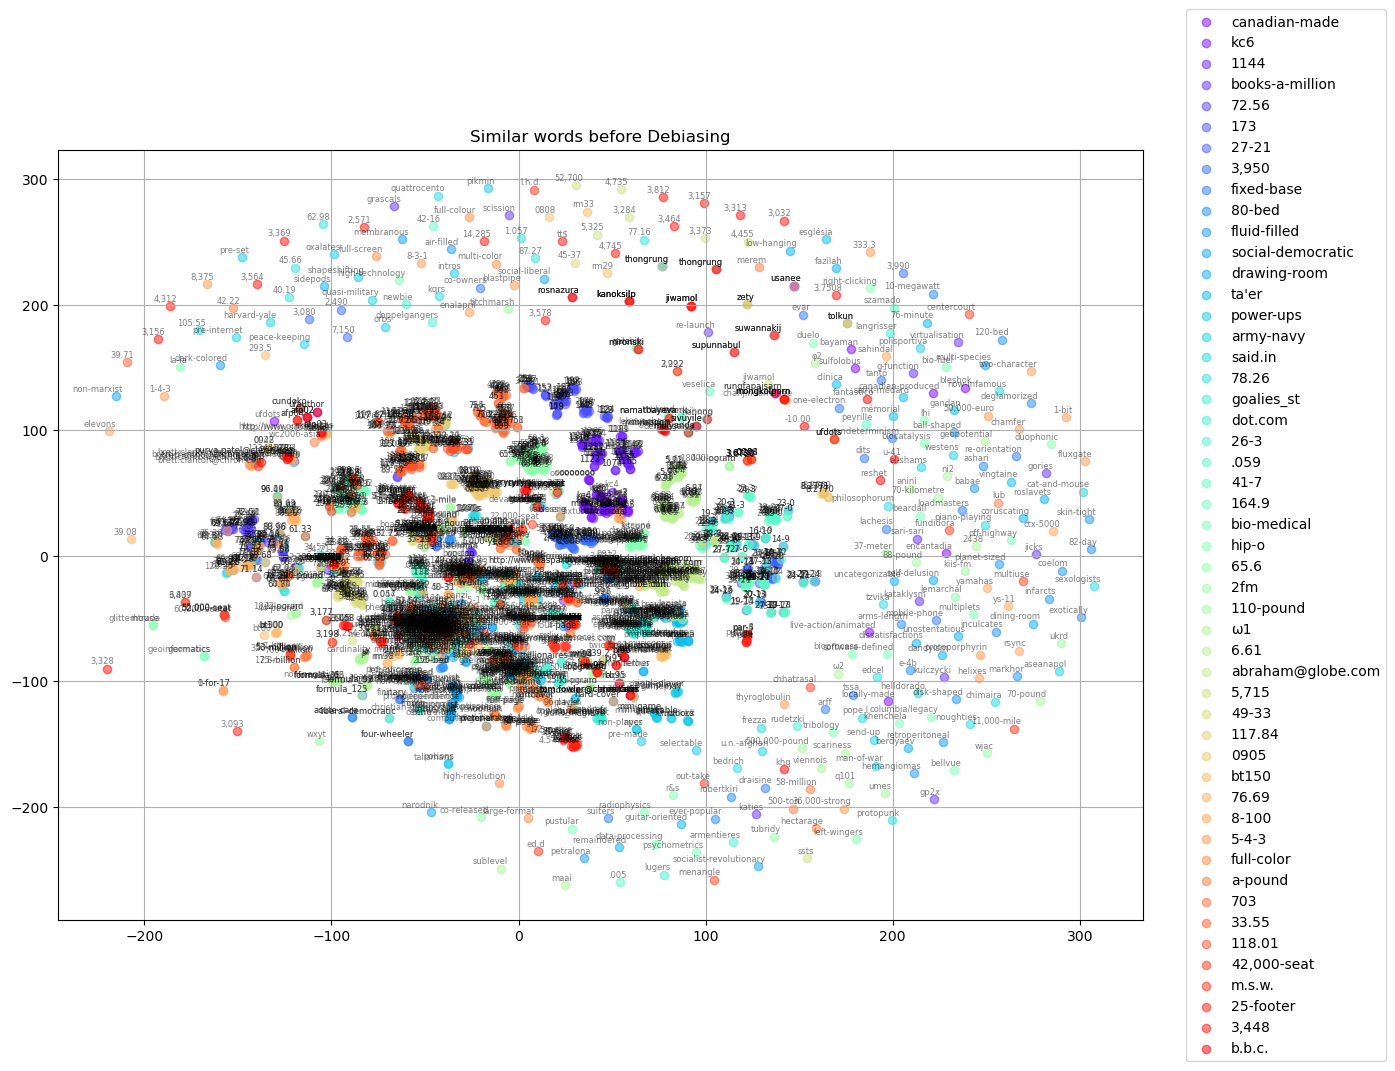

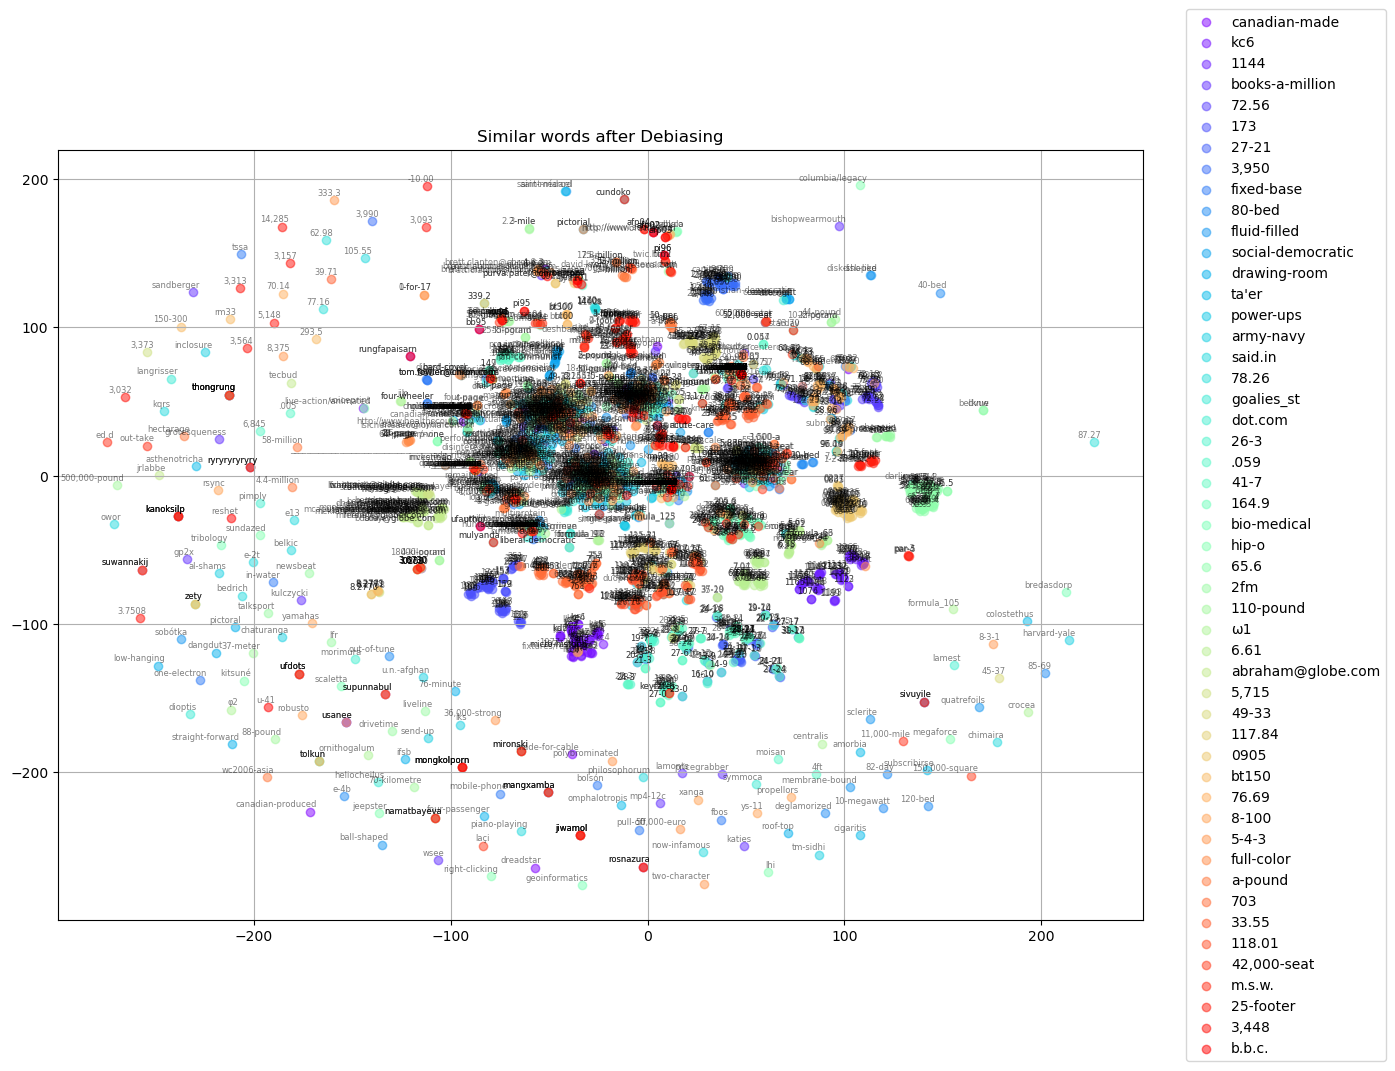

In [62]:
from sklearn.manifold import TSNE
import numpy as np
from Scripts.Visualization import tsne_plot_similar_words

#This approach was inspired by the following blog post:https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d
keys = random_words
embedding_clusters, db_embedding_clusters, word_clusters = get_embeddings_neighbors(
    keys, glove.model, model_debiased_punct, 50)

n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=2, n_components=2,
                        init='pca', n_iter=3500, random_state=42)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
db_embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    db_embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

tsne_plot_similar_words('Similar words before Debiasing',
                        keys, embeddings_en_2d, word_clusters, 0.5)
tsne_plot_similar_words('Similar words after Debiasing',
                        keys, db_embeddings_en_2d, word_clusters, 0.5)


### Name Analysis

In [ ]:
gender_bias_original2 = compute_direct_bias(
    deb_dict_gender, neutral_words, race_direction)


In [ ]:
names_white= list(w.lower() for w in names_ethnicity['White'] if w.lower() in set(vocab_cleaned))
names_black= list(w.lower() for w in names_ethnicity['Black'] if w.lower() in set(vocab_cleaned))
names_latino= list(w.lower() for w in names_ethnicity['Hispanic'] if w.lower() in set(vocab_cleaned))
#euroam_names_emb= list(w for w in euroam_names if w in set(vocab_cleaned))

In [ ]:
bias_df_names = get_bias_score_df_from_list(
    gender_bias_original, gender_bias_after_debiasing, names_black, vocab_cleaned, deb_vocab_gender)
plot_bias_bar(
    bias_df_names, "Gender bias on english names (original vs debiased)", "Names")

In [ ]:
k_neigh= get_k_nearest_neighbors(names_black[:17], dict_vec_cleaned, vocab_cleaned, vectors_cleaned, word2idx_cleaned, k=50)

In [ ]:
k_neigh

In [ ]:
list_neigh = get_list_neighbors(k_neigh)


In [ ]:
get_frequency_original_neighbors(
    names_black[:17], list_neigh, deb_dict_gender, deb_vocab_gender, deb_vect_gender, deb_word2idx_gender, neighbours_num=50)


In [ ]:
model_debiased = create_KeyedVectors(deb_vect_gender, deb_vocab_gender, 50)


In [ ]:
gendered_words_before_and_after=finding_neighbors_before_after(names_black, model_original, model_debiased, topn=50)

In [ ]:
keys2=names_black
embedding_clusters, db_embedding_clusters, word_clusters = get_embeddings_neighbors(keys2, model_original, model_debiased, topn)

n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=2, n_components=2,
                        init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
db_embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    db_embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


tsne_plot_similar_words('Similar words before Debiasing', keys2, embeddings_en_2d, word_clusters, 0.7)
tsne_plot_similar_words('Similar words after Debiasing',
                        keys2, db_embeddings_en_2d, word_clusters, 0.7)


In [ ]:
# get tuples of biases and counts of masculine/feminine NN for each word (for bias-by-neighbors)

def bias_by_neighbors(dict_vect, vocab, vectors, w2i, neighbours_num=100):

    tuples = []
    for word in tqdm(vocab):

        _, top = topK(word, dict_vect, vocab, vectors, w2i,
                      k=neighbours_num+5)

        m = 0
        f = 0
        for t in top:
            if gender_bias_original[t] < 0:
                m += 1
            else:
                f += 1

        tuples.append(
            (word, gender_bias_original[word], gender_bias_after_debiasing[word], m, f))

    return tuples


bias_by_neighbors(dict_vec_cleaned, vocab_cleaned,
                  vectors_cleaned, word2idx_cleaned, neighbours_num=50)

gendered_names = ["ruth", "charlotte", "abigail", "sophie", "nichole",
                  "emma", "olivia", "ava", "isabella", "sophia", "charlotte", "mia", "amelia"]
# "james", "john", "robert", "michael", "william", "david", "richard", "joseph", "thomas", "ariel", "mike", "nurse", "secretary", "nursery"]
#words_chosen = ["miss", "mrs", "mr", "john", "rachel",
# "wife", "mom", "family", "father", "lady", "he", "she"]

gendered_words_before_and_after = finding_neighbors_before_after(
    gendered_names, model_original, model_debiased, topn=3)
keys2 = gendered_names
embedding_clusters, db_embedding_clusters, word_clusters = get_embeddings_neighbors(
    keys2, model_original, model_debiased, topn)

n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=2, n_components=2,
                        init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
db_embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    db_embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


tsne_plot_similar_words('Similar words before Debiasing',
                        keys2, embeddings_en_2d, word_clusters, 0.7)
tsne_plot_similar_words('Similar words after Debiasing',
                        keys2, db_embeddings_en_2d, word_clusters, 0.7)


In [ ]:
race_direction = identify_bias_subspace(
    deb_dict_gender, def_set_race, 1, centralizing=True)

### MAC Scores

In [ ]:
targets = [["he", "she"],
            ["his", "hers"],
            ["son", "daughter"],
            ["father", "mother"],
            ["male", "female"],
            ["boy", "girl"],
            ["uncle", "aunt"]]

Attribtutes = [["manager", "executive", "doctor", "lawyer", "programmer", "scientist",
                "soldier", "supervisor", "rancher", "janitor", "firefighter", "officer"], ["secretary", "nurse", "clerk", "artist", "homemaker", "dancer", "singer", "librarian", "maid", "hairdresser", "stylist", "receptionist", "counselor"]]


In [ ]:
debiasedMAC, debiasedDistribution=multiclass_evaluation_MAC(
    debiased_dict, targets, Attribtutes)

originalMAC,originalDistribution = multiclass_evaluation_MAC(
    dict_vec_cleaned, targets, Attribtutes)


In [ ]:
from scipy.stats import ttest_rel, spearmanr
statistics, pvalue = ttest_rel(originalDistribution, debiasedDistribution)


### Bias by neighbor

In [ ]:
c_w2i, c_vocab, female_words, male_words, y_true=getting_biased_words(
    gender_bias_original, def_sets['gender'], 1000, word2idx_cleaned)


In [ ]:
biased_words=female_words+male_words

In [ ]:


k_neighbors=finding_neighbors_before_after(
    biased_words, model_original, model_debiased, topn=100)


In [ ]:
#take k_neighbors dictionary and

In [ ]:
calculate_bias_by_clustering(model_original, model_debiased, biased_words, 50)

#### Race

In [ ]:

deb_vect_race, deb_vocab_race, deb_word2idx_race, deb_dict_race = hard_debias(vectors,
                                                                              dict_vectors,
                                                                              word2idx_cleaned,
                                                                              vocab_cleaned,
                                                                              equalizing_lists['race'],
                                                                              def_set_race,
                                                                              1,
                                                                              normalize_dir=False,
                                                                              normalize=None,
                                                                              centralizing=True)


In [ ]:
neig_freq_race= get_frequency_original_neighbors(
    random_words, list_neigh, deb_dict_race, deb_vocab_race, deb_vect_race, deb_word2idx_race, neighbours_num=50)


In [ ]:
pd.DataFrame(neig_freq_race, columns=['word', 'previous_neighbours', 'freq'])

In [ ]:
## Finding race Debiased Words.
race_debiased = create_KeyedVectors(deb_vect_race, deb_vocab_race, 50)
finding_neighbors_before_after(random_words, model_original, race_debiased, topn=3)
joined_debiased = create_KeyedVectors(deb_vect_joined, deb_vocab_joined, 50)
finding_neighbors_before_after(
    random_words, model_original, joined_debiased, topn=2)


### Saving Embeddings on a txt file.
- And loading them as a Gensim model object

In [ ]:
#Saving the debiased vectors and vocab to a text file
glove.save_in_word2vec_format(
    debiased_vectors, debiased_vocab, "./Data/vecs.50.cleaned.txt")

#Loading the vectors into a KeyedVectors object 'model_cleaned' that we can use to find the most similar words to a given word
model_cleaned, _, _ = load_word_vectors(
    fname="./Data/vecs.50.cleaned.txt")



## INLP

In [ ]:
from Scripts.INLP import *


In [ ]:
model_original = create_KeyedVectors(vectors_cleaned, vocab_cleaned, 50)


In [ ]:
num_vectors_per_class = 7500

gender_direction = identify_bias_subspace(
    dict_vec_cleaned, def_set_gender, 1, centralizing=False)
gender_direction = np.squeeze(gender_direction)

gender_unit_vec = gender_direction/np.linalg.norm(gender_direction)
fem_words_and_scores, masc_words_and_scores, neut_words_and_scores = getting_classes_for_INLP(
    gender_vector=gender_direction, model=model_original, n=7500)

masc_words, masc_scores = list(zip(*masc_words_and_scores))
neut_words, neut_scores = list(zip(*neut_words_and_scores))
fem_words, fem_scores = list(zip(*fem_words_and_scores))

#getting the vectors corresponding to masc_words from the dict_vec_cleaned
masc_vecs = [vector for word, vector in dict_vec_cleaned.items()
             if word in masc_words]
fem_vecs = [vector for word, vector in dict_vec_cleaned.items()
            if word in fem_words]
neut_vecs = [vector for word, vector in dict_vec_cleaned.items()
             if word in neut_words]

#turn the list of vectors into a numpy array
masc_vecs = np.array(masc_vecs)
fem_vecs = np.array(fem_vecs)
neut_vecs = np.array(neut_vecs)

#masc_vecs, fem_vecs = model_original.get_vectors_from_list(masc_words), model_original.get_vectors_from_list(fem_words)
#neut_vecs = model_original.get_vectors_from_list(neut_words)

n = min(3000, num_vectors_per_class)
all_significantly_biased_words = masc_words[:n] + fem_words[:n]
all_significantly_biased_vecs = np.concatenate((masc_vecs[:n], fem_vecs[:n]))
all_significantly_biased_labels = np.concatenate((np.zeros(n, dtype=int),
                                                  np.ones(n, dtype=int)))

all_significantly_biased_words, all_significantly_biased_vecs, all_significantly_biased_labels = sklearn.utils.shuffle(
    all_significantly_biased_words, all_significantly_biased_vecs, all_significantly_biased_labels)
#print(np.random.choice(masc_words, size = 75))
print("TOP MASC:", masc_words[:50])
print("-------------------------")
print("TOP FEM:", fem_words[:50])
print("-------------------------")
print("Random Neutral:", neut_words[:50])


In [ ]:
#random.seed(42)
#np.random.seed(42)

X = np.concatenate((masc_vecs, fem_vecs, neut_vecs), axis=0)
#X = (X - np.mean(X, axis = 0, keepdims = True)) / np.std(X, axis = 0)
y_masc = np.ones(masc_vecs.shape[0], dtype=int)
y_fem = np.zeros(fem_vecs.shape[0], dtype=int)
y_neut = -np.ones(neut_vecs.shape[0], dtype=int)
#y = np.concatenate((masc_scores, fem_scores, neut_scores))#np.concatenate((y_masc, y_fem))
y = np.concatenate((y_masc, y_fem, y_neut))
X_train_dev, X_test, y_train_dev, Y_test = sklearn.model_selection.train_test_split(
    X, y, test_size=0.3, random_state=42)
X_train, X_dev, Y_train, Y_dev = sklearn.model_selection.train_test_split(
    X_train_dev, y_train_dev, test_size=0.3, random_state=42)
print("Train size: {}; Dev size: {}; Test size: {}".format(
    X_train.shape[0], X_dev.shape[0], X_test.shape[0]))


In [ ]:
from sklearn.svm import LinearSVC, SVC
gender_clf = LinearSVC
#gender_clf = SGDClassifier
#gender_clf = LogisticRegression
#gender_clf = LinearDiscriminantAnalysis
#gender_clf = Perceptron

params_svc = {'penalty': 'l2', 'fit_intercept': False,
              'class_weight': None, "dual": False, 'random_state': 42}
params_sgd = {'penalty': 'l2', 'fit_intercept': False,
              'class_weight': None, 'max_iter': 1000, 'random_state': 42}
params = params_svc
#params = {'loss': 'hinge', 'n_jobs': 16, 'penalty': 'l2', 'max_iter': 2500, 'random_state': 0}
#params = {}
n = 35
min_acc = 0
dropout_rate = 0


In [ ]:
P, rowspace_projs, Ws = get_debiasing_projection(gender_clf, params, n, 50, min_acc,
                                                 X_train, Y_train, X_dev, Y_dev,
                                                 is_autoregressive=True, Y_train_main=None, Y_dev_main=None,
                                                 dropout_rate=0)


In [ ]:
inlp_vectors = (P.dot(vectors_cleaned.T)).T
inlp_dict = get_debiased_dict(inlp_vectors, word2idx_cleaned)
inlp_vocab = list(inlp_dict.keys())


In [ ]:
inlp_freq=get_frequency_original_neighbors(
    random_words, list_neigh, inlp_dict, inlp_vocab, inlp_vectors, word2idx_cleaned, neighbours_num=50)


In [ ]:
inlp_freq

In [ ]:
import plotly_express as px
df2=pd.DataFrame(inlp_freq, columns=['word', 'previous_neighbours', 'freq'])

#plot the frequency of the original neighbours in the debiased network in a horizontal bar chart

fig = px.bar(df2, x='word', y='freq', title='Proportion of original 50 neighbours in the debiased network',
             labels={'freq': 'Proportion', 'word': 'Word'},
             height=500, width=1000)
#update the layout of the plot: update the y axis to be between 0 and 0.5 and the x axis to include all ticks
fig.update_layout(yaxis=dict(range=[0, 0.5]))

fig.show()


In [ ]:
distances_original_inlp, distances_debiased_inlp = get_distance_to_neighbors(random_words, list_neigh,
                                                                   dict_vec_cleaned, inlp_dict)


In [ ]:
bias_df3 = get_bias_score_df_from_list(
    gender_bias_original, gender_bias_after_debiasing, random_words, vocab_cleaned, deb_vocab_gender)
plot_bias_bar(
    bias_df3, "Gender bias on occupations (original vs debiased)", "Occupations")


## Testing Bias Direction from Scratch

In [ ]:
gender_dir=identify_bias_subspace(dict_vec_cleaned, def_set_gender, 1, centralizing=True)


In [ ]:
gender_dir = np.squeeze(gender_dir)
gender_dir


In [ ]:
race_dir=identify_bias_subspace(dict_vec_cleaned, def_set_race, 1, centralizing=True)


In [ ]:
race_dir = np.squeeze(race_dir)
race_dir


In [ ]:
wv_gender=neutralize_words(vocab_cleaned, vectors, word2idx_cleaned, gender_dir)
wv_gender

In [ ]:
equalize_words(wv_gender, vocab_cleaned, word2idx_cleaned,
               equalizing_lists['gender'], gender_dir)


In [ ]:
wv_race=neutralize_words(vocab_cleaned, vectors, word2idx_cleaned, race_dir)
wv_race

In [ ]:
equalize_words(wv_race, vocab_cleaned, word2idx_cleaned,
               equalizing_lists['race'], race_dir)


In [ ]:
wv_race.shape

In [ ]:
gender_dict=get_debiased_dict(wv_gender, word2idx_cleaned)

In [ ]:
race_dict=get_debiased_dict(wv_race, word2idx_cleaned)

In [ ]:
len(word2idx_cleaned)

In [ ]:
k_gender= get_k_nearest_neighbors(random_words, gender_dict, list(gender_dict.keys()), wv_gender, word2idx_cleaned, k=50)

In [ ]:
k_race= get_k_nearest_neighbors(random_words, race_dict, list(race_dict.keys()), wv_race, word2idx_cleaned, k=50)

In [ ]:
k_gender[random_words[0]]

In [ ]:
k_race[random_words[0]]==k_gender[random_words[0]]

In [ ]:
#get the first element of each tuple in the list k_race[random_words[0]]
first_race=[k_race[random_words[0]][i][0] for i in range(len(k_race[random_words[0]]))]
first_gender = [k_gender[random_words[0]][i][0]
              for i in range(len(k_gender[random_words[0]]))]



In [ ]:
[first_race[i]==first_gender[i] for i in range(len(first_gender))]

In [ ]:
gen_freq = get_frequency_original_networks(
    random_words, list_neigh, gender_dict, list(gender_dict.keys()), wv_gender, word2idx_cleaned, neighbours_num=50)


In [ ]:
race_freq = get_frequency_original_networks(
    random_words, list_neigh, race_dict, list(race_dict.keys()), wv_race, word2idx_cleaned, neighbours_num=50)


In [ ]:
gen_freq==race_freq